In [2]:
%load_ext autoreload
%autoreload 2
#%matplotlib notebook

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from grating import *
from ext_signal import *

lum in LMS = [0.45436904 0.47353315 0.0720978 ]
[[1.31265115 0.37916654 0.17658182]
 [0.37916654 0.43588297 0.06613005]
 [0.17658182 0.06613005 1.03101131]]
[[10.82668925 -2.48855249  0.0461736 ]
 [-2.48855249  1.38614356 -0.12768065]
 [ 0.0461736  -0.12768065  1.15767798]]


In [52]:
def acuity(ecc):
    k = 0.202313
    log40 = np.log(40)
    cpd = np.exp(-k*ecc + log40)
    return 1/cpd/4

In [59]:
K_onC = 29.13289963
K_onS = 23.17378917
K_offC = 22.71914498
K_offS = 12.53276353
r_C = 0.03
#r_C = 0.0065
r_S = r_C*6
cov = 0.53753
def zeroCross(k1, k2, r1, r2):
    return np.sqrt(np.log(k1/k2)/(r2*r2 - r1*r1))*r1*r2
SF = 1.0/(zeroCross(K_offC, K_onS*cov, r_C, r_S)*2 + zeroCross(K_onC, K_offS*cov, r_C, r_S)*2)
print(SF)

8.277644707576945


In [10]:
# color-drifting
SF = 15
TF = 8
time = np.array([1/TF])
video_fn = 'color_drifting-SF15-TF8_d0-micro'
#video_fn = 'grey'
stimulus_fn = video_fn + '.bin'
#crest = [0.5,0.5,0.5]
#valley = [0.5,0.5,0.5]
#crest = [1.0,0.0,0.5]
#valley = [0.0,1.0,0.5]
#crest = [1.0,0.0,0.0]
#valley = [0.0,1.0,0.0]

crest = np.array([0.50650651, 0.27006487, 0.3609756])
valley = np.array([0.28128128, 0.48617513, 0.3609756])
#crest = np.array([0.393893895, 0.37812, 0.3609756])
#valley = np.array([0.393893895, 0.37812, 0.3609756])

inputLMS = True
buffer_deg = 0.1  
range_deg = 0.18 # eccentricity from the origin

orient = np.array([np.pi*0/6])
phase = 8.8*np.pi
center = np.pi/2
wing = np.pi/2
sharpness = 1
LMS_series = generate_grating(1.0, SF, TF, orient, 512, crest, valley, video_fn, time, phase, sharpness, frameRate = 120, ecc = range_deg, buffer_ecc = buffer_deg, gtype='drifting', neye = 2, bar = False, center = center, wing = wing, inputLMS = inputLMS)

print(LMS_series.shape)
nseq = LMS_series.size
for i in range(nseq):
    print([np.min(LMS_series[i][:,0]), np.max(LMS_series[i][:,0])])
    print([np.min(LMS_series[i][:,1]), np.max(LMS_series[i][:,1])])
    print([np.min(LMS_series[i][:,2]), np.max(LMS_series[i][:,2])])

with open(stimulus_fn, 'wb') as f:
    np.array([LMS_series[0].shape[0], LMS_series[0].shape[2], LMS_series[0].shape[3]], dtype='i4').tofile(f)
    mean_value = np.array([np.mean(LMS_series[0][:,0,:,:]), np.mean(LMS_series[0][:,1,:,:]), np.mean(LMS_series[0][:,2,:,:])])
    mean_value.astype('f4').tofile(f) # init_luminance
    np.array([buffer_deg, range_deg], dtype='f4').tofile(f)
    print([buffer_deg, range_deg])
    for i in range(nseq):
        print(i)
        LMS_series[i].astype('f4').tofile(f)
print(mean_value)

crest in sRGB: [0.99960262 0.4916256  0.6119184 ]
valley in sRGB: [0.04124408 0.73805437 0.59827713]
exact 15 frames in total
sharpness=1.0
(1,)
[0.28128136546265436, 0.5065064245373456]
[0.27006495200394093, 0.48617504799605904]
[0.3609756, 0.3609756]
[0.1, 0.18]
0
[0.39389389 0.37812    0.3609756 ]


In [36]:
# cyclop
video_fn = 'reverse_retinal_bar'
stimulus_fn = video_fn + '.bin'
crest = [1,1,1] # [0,1]
valley = [0,0,0]
buffer_deg = 0.12
range_deg = 0.1 # eccentricity from the original
SF = 8
TF = 20
nseq = 2
#orient = np.array([np.pi/4, np.pi*3/4])
orient = np.array([np.pi*1/4, -np.pi*3/4])
time = [36/120, 36/120]
sharpness = 15
phase = 12*np.pi/2
center = np.pi/2
wing = np.pi/2
inputLMS = False

LMS_series = generate_grating(1.0, SF, TF, orient, 512, crest, valley, video_fn, time, phase, sharpness, frameRate = 120, ecc = range_deg, buffer_ecc = buffer_deg, gtype='drifting', neye = 1, bar = True, center = center, wing = wing, inputLMS = inputLMS)

#start = 0
#end = 60
#LMS_inRGB = video_to_LMS_time_series('test', start, end)
print(LMS_series.shape)
for i in range(nseq):
    print([np.min(LMS_series[i]), np.max(LMS_series[i])])

with open(stimulus_fn, 'wb') as f:
    np.array([LMS_series[0].shape[0], LMS_series[0].shape[2], LMS_series[0].shape[3]], dtype='i4').tofile(f)
    mean_value = np.array([np.mean(LMS_series[0][:,0,:,:]), np.mean(LMS_series[0][:,1,:,:]), np.mean(LMS_series[0][:,2,:,:])])
    mean_value.astype('f4').tofile(f) # init_luminance
    np.array([buffer_deg, range_deg], dtype='f4').tofile(f)
    for i in range(nseq):
        LMS_series[i].astype('f4').tofile(f)
print(mean_value)

exact 36 frames in total
sharpness=15.0
exact 36 frames in total
sharpness=15.0
(2,)
[0.2031745139032876, 1.087430756626398]
[0.2031745139032876, 1.087430756626398]
[0.25641437 0.27969171 0.29374603]


In [ ]:
stimulus_fn = 'stimulus.bin'
with open(stimulus_fn, 'rb') as f:
    np.array([LMS_series[0].shape[0], LMS_series[0].shape[2], LMS_series[0].shape[3]], dtype='i4').tofile(f)
    mean_value = np.array([np.mean(LMS_series[0][:,0,:,:]), np.mean(LMS_series[0][:,1,:,:]), np.mean(LMS_series[0][:,2,:,:])])
    mean_value.astype('f4').tofile(f) # init_luminance
    np.array([buffer_deg, range_deg], dtype='f4').tofile(f)
    for i in range(nseq):
        LMS_series[i].astype('f4').tofile(f)

dpi = 600
fig = plt.figure('LMS revisit', dpi = dpi)
it = 0
iseq = 0
npixel = 512
xx, yy = np.meshgrid(np.arange(npixel), np.arange(npixel))
ax = fig.add_subplot(121)
tristimulus_value = np.reshape(LMS_series[iseq][it,:,:,:], (3,xx.size))
assert((tristimulus_value>=0).all())
assert((tristimulus_value<=1).all())
if inputLMS:
    tristimulus_value = np.matmul(LMS2sRGB, tristimulus_value)
    if (tristimulus_value<0).any() or (tristimulus_value>1).any():
        print(np.max(tristimulus_value))
        print(np.min(tristimulus_value))
        assert((tristimulus_value>=0).all())
        assert((tristimulus_value<=1).all())
    tristimulus_value = apply_sRGB_gamma(tristimulus_value)

color = tristimulus_value.T

ax.scatter(xx.flatten(), yy.flatten(), s = (72/dpi*10)**2, c = color, marker='.',linewidths=0.0)
ax.set_xlim([0,npixel])
ax.set_ylim([0,npixel])
ax.set_aspect('equal')
ax = fig.add_subplot(122)
it = 1

tristimulus_value = np.reshape(LMS_series[iseq][it, :, :,:], (3,xx.size))
assert((tristimulus_value>=0).all())
assert((tristimulus_value<=1).all())
if inputLMS:
    tristimulus_value = np.matmul(LMS2sRGB, tristimulus_value)
    if (tristimulus_value<0).any() or (tristimulus_value>1).any():
        print(np.max(tristimulus_value))
        print(np.min(tristimulus_value))
        assert((tristimulus_value>=0).all())
        assert((tristimulus_value<=1).all())
    tristimulus_value = apply_sRGB_gamma(tristimulus_value)
color = tristimulus_value.T

ax.scatter(xx.flatten(), yy.flatten(), s = (72/dpi*10)**2, c = color, marker='.',linewidths=0.0)
ax.set_xlim([0,npixel])
ax.set_ylim([0,npixel])
ax.set_aspect('equal')

In [11]:
#video_fn = 'L-isolating'
# sRGB compatible
#crest = np.array([0.59059059, 0.49999039, 0.49991416])
#valley = np.array([0.40940941, 0.49999039, 0.49991416])
# XYZ
# CAT02
#crest = np.array([0.78178178, 0.49999038, 0.49991416])
#valley = np.array([0.24524525, 0.49999038, 0.49991416])

#video_fn = 'M-isolating'
# sRGB compatible
#crest = np.array([0.49998918, 0.60760761, 0.49991416])
#valley = np.array([0.49998918, 0.39239239, 0.49991416])
# XYZ
# CAT02
#crest = np.array([0.49998918, 0.91991992, 0.49991416]) 
#valley = np.array([0.49998918, 0.03603604, 0.49991416])


video_fn = 'equiluminant_d2'
# sRGB compatible
#crest = np.array([0.56156156, 0.46516206, 0.49991416])
#valley = np.array([0.43843844, 0.53478416, 0.49991416])

# XYZ space
# CAT02
crest = np.array([0.89289289, 0.2819068, 0.54363796])
valley = np.array([0.16016016, 0.98498549, 0.54363796])
# Hunt 
#crest = np.array([0.70970971, 0.38138913, 0.49991416])
#valley = np.array([0.31031031, 0.60723642, 0.49991416])

inputLMS = True
buffer_deg = 1.0
range_deg = 2.5 # eccentricity from the origin
TF = 8
SF = 3

orient = np.array([np.pi*1/4])
time = np.array([0.125])
phase = 8.8*np.pi
center = np.pi/2
wing = np.pi/2
sharpness = 1
LMS_series = generate_grating(1.0, SF, TF, orient, 512, crest, valley, video_fn, time, phase, sharpness, frameRate = 120, ecc = range_deg, buffer_ecc = buffer_deg, gtype='drifting', neye = 2, bar = False, center = center, wing = wing, inputLMS = inputLMS)

print(LMS_series.shape)
nseq = LMS_series.size
for i in range(nseq):
    print([np.min(LMS_series[i]), np.max(LMS_series[i])])

stimulus_fn = video_fn + '.bin'
with open(stimulus_fn, 'wb') as f:
    np.array([LMS_series[0].shape[0], LMS_series[0].shape[2], LMS_series[0].shape[3]], dtype='i4').tofile(f)
    mean_value = np.array([np.mean(LMS_series[0][:,0,:,:]), np.mean(LMS_series[0][:,1,:,:]), np.mean(LMS_series[0][:,2,:,:])])
    mean_value.astype('f4').tofile(f) # init_luminance
    np.array([buffer_deg, range_deg], dtype='f4').tofile(f)
    print([buffer_deg, range_deg])
    for i in range(nseq):
        print(i)
        LMS_series[i].astype('f4').tofile(f)
print(mean_value)

crest in sRGB: [2.07986002 0.1388406  0.51025349]
valley in sRGB: [-1.1601429   1.10746718  0.45788807]


Exception: crest and valley in LMS is out of the sRGB space

In [136]:
crest = np.array([0.89289289, 0.2819068, 0.54363796])
valley = np.array([0.16016016, 0.98498549, 0.54363796])
mL = (crest[0] + valley[0])/2
mM = (crest[1] + valley[1])/2
print(f'{crest[0]/mL - 1, mL, valley[0]/mL - 1}')
print(f'{crest[1]/mM - 1, mM, valley[1]/mM - 1}')

(0.6958174899165814, 0.526526525, -0.6958174899165811)
(-0.5549632715816748, 0.633446145, 0.554963271581675)


In [ ]:
# cyclop
video_fn = 'light_bar_cyclop_flat'
stimulus_fn = video_fn + '.bin'
crest = [255,255,255]
valley = [0,0,0]
buffer_deg = 0.525
range_deg = 0.25 # eccentricity from the origin
SF = 4
TF = 8
#nseq = 2
#orient = np.array([np.pi*1/4, np.pi*3/4])
#time = [0.5, 0.5]
#time = np.array([1.2, 1.2])
#orient = np.array([np.pi*1/4, np.pi*3/4])
orient = 0
time = np.array([1.2])
#phase = 8.8*np.pi
phase = 3*np.pi
center = np.pi/2
wing = np.pi/2
sharpness = 1
LMS_series = generate_grating(1.0, SF, TF, orient, 256, crest, valley, video_fn, time, phase, sharpness, frameRate = 120, ecc = range_deg, buffer_ecc = buffer_deg, gtype='drifting', neye = 1, bar = True, center = center, wing = wing)
#start = 0
#end = 60
#LMS_inRGB = video_to_LMS_time_series('test', start, end)
print(LMS_series.shape)
nseq = LMS_series.size
for i in range(nseq):
    print([np.min(LMS_series[i]), np.max(LMS_series[i])])

with open(stimulus_fn, 'wb') as f:
    np.array([LMS_series[0].shape[0], LMS_series[0].shape[2], LMS_series[0].shape[3]], dtype='i4').tofile(f)
    mean_value = np.array([np.mean(LMS_series[0][:,0,:,:]), np.mean(LMS_series[0][:,1,:,:]), np.mean(LMS_series[0][:,2,:,:])])
    mean_value.astype('f4').tofile(f) # init_luminance
    np.array([buffer_deg, range_deg], dtype='f4').tofile(f)
    print([buffer_deg, range_deg])
    for i in range(nseq):
        LMS_series[i].astype('f4').tofile(f)
print(mean_value)

In [ ]:
# cyclop
video_fn = 'light_bar_cyclop_orth'
stimulus_fn = video_fn + '.bin'
crest = [255,255,255]
valley = [0,0,0]
buffer_deg = 0.525
range_deg = 0.25 # eccentricity from the origin
SF = 4
TF = 8

orient = np.array([np.pi*3/4, np.pi*1/4])
time = np.array([1.2, 1.2])
phase = 8.8*np.pi
center = np.pi/2
wing = np.pi/2
sharpness = 1
LMS_series = generate_grating(1.0, SF, TF, orient, 256, crest, valley, video_fn, time, phase, sharpness, frameRate = 120, ecc = range_deg, buffer_ecc = buffer_deg, gtype='drifting', neye = 1, bar = True, center = center, wing = wing)
#start = 0
#end = 60
#LMS_inRGB = video_to_LMS_time_series('test', start, end)
print(LMS_series.shape)
nseq = LMS_series.size
for i in range(nseq):
    print([np.min(LMS_series[i]), np.max(LMS_series[i])])

with open(stimulus_fn, 'wb') as f:
    np.array([LMS_series[0].shape[0], LMS_series[0].shape[2], LMS_series[0].shape[3]], dtype='i4').tofile(f)
    mean_value = np.array([np.mean(LMS_series[0][:,0,:,:]), np.mean(LMS_series[0][:,1,:,:]), np.mean(LMS_series[0][:,2,:,:])])
    mean_value.astype('f4').tofile(f) # init_luminance
    np.array([buffer_deg, range_deg], dtype='f4').tofile(f)
    print([buffer_deg, range_deg])
    for i in range(nseq):
        LMS_series[i].astype('f4').tofile(f)
print(mean_value)

In [ ]:
# random
stimulus_fn = 'random_cyclop.bin'
video_fn = 'color_random_cyclop'
c0 = [127,127,0]
buffer_deg = 0.5
range_deg = 0.25 # eccentricity from the origin
cSize = 0.05
nseq = 2
time = [0.5, 0.5]
amp = 1
LMS_series = generate_random(amp, cSize, c0, video_fn, time, frameRate = 120, ecc = range_deg, buffer_ecc = buffer_deg, neye = 1, gtype='normal')
#start = 0
#end = 60
#LMS_inRGB = video_to_LMS_time_series('test', start, end)
print(LMS_series.shape)
for i in range(nseq):
    print([np.min(LMS_series[i]), np.max(LMS_series[i])])

with open(stimulus_fn, 'wb') as f:
    np.array([LMS_series[0].shape[0], LMS_series[0].shape[2], LMS_series[0].shape[3]], dtype='i4').tofile(f)
    mean_value = np.array([np.mean(LMS_series[0][:,0,:,:]), np.mean(LMS_series[0][:,1,:,:]), np.mean(LMS_series[0][:,2,:,:])])
    mean_value.astype('f4').tofile(f) # init_luminance
    np.array([buffer_deg, range_deg], dtype='f4').tofile(f)
    for i in range(nseq):
        LMS_series[i].astype('f4').tofile(f)
print(mean_value)

In [ ]:
precision = 'f4'

In [ ]:
#output = "C:/Users/gueux/source/repos/patchV11/x64/Debug/storage.bin"
#output = "C:/Users/gueux/source/repos/patchV11/patchV11/LGN_gallery.bin"
output = "C:/Users/gueux/patchV1/src/LGN_gallery.bin"
with open(output, 'rb') as f:
    nLGN = np.fromfile(f, 'u4', 1)[0]
    nType = np.fromfile(f, 'u4', 1)[0]
    nKernelSample = np.fromfile(f, 'u4', 1)[0]
    nSample = np.fromfile(f, 'u4', 1)[0]
    max_convol = np.fromfile(f, 'f4', nLGN)
    tw = np.fromfile(f, 'f4', nLGN*nType*nKernelSample).reshape((nLGN,nType,nKernelSample))
    #np.fromfile(f, precision, nLGN*nType*nKernelSample) # skip
    sw = np.fromfile(f, 'f4', nSample)
    sc = np.fromfile(f, 'f4', 2*nLGN*nType*nSample).reshape((2,nLGN,nType,nSample))
print(f'nLGN = {nLGN}, nType = {nType}, nKernelSample = {nKernelSample}, nSample = {nSample}')

In [ ]:
print(f'Ix = {[np.min(sc[0,:37027,:,:]), np.max(sc[0,:37027,:,:])]}')
print(f'Cx = {[np.min(sc[0,37027:,:,:]), np.max(sc[0,37027:,:,:])]}')
print(f'Iy = {[np.min(sc[1,:37027,:,:]), np.max(sc[1,:37027,:,:])]}')
print(f'Cy = {[np.min(sc[1,37027:,:,:]), np.max(sc[1,37027:,:,:])]}')

In [ ]:
#output = "C:/Users/gueux/source/repos/patchV11/x64/Debug/LGN.bin"
output = "C:/Users/gueux/source/repos/patchV11/patchV11/LGN.bin"
#output = "LGN.bin"
precision = 'f4'
with open(output, 'rb') as f:
    LGN_type = np.fromfile(f, 'u4', nLGN)
    LGN_polar = np.fromfile(f, precision, 2*nLGN).reshape(2,nLGN)
    LGN_ecc = np.fromfile(f, precision, 2*nLGN).reshape(2,nLGN)
    LGN_rw = np.fromfile(f, precision, 2*nLGN).reshape(2,nLGN)
    LGN_rh = np.fromfile(f, precision, 2*nLGN).reshape(2,nLGN)
    LGN_orient = np.fromfile(f, precision, 2*nLGN).reshape(2,nLGN)
    LGN_k = np.fromfile(f, precision, 2*nLGN).reshape(2,nLGN)
    LGN_ratio = np.fromfile(f, precision, 2*nLGN).reshape(2,nLGN)
    tau_R = np.fromfile(f, precision, 2*nLGN).reshape(2,nLGN)
    tau_D = np.fromfile(f, precision, 2*nLGN).reshape(2,nLGN)
    nR = np.fromfile(f, precision, 2*nLGN).reshape(2,nLGN)
    nD = np.fromfile(f, precision, 2*nLGN).reshape(2,nLGN)
    delay = np.fromfile(f, precision, 2*nLGN).reshape(2,nLGN)
    spont = np.fromfile(f, precision, nLGN)
    c50 = np.fromfile(f, precision, nLGN)
    sharpness = np.fromfile(f, precision, nLGN)
    coneType = np.fromfile(f, 'u4', 2*nLGN).reshape(2,nLGN)

print(f'LGN_type[{np.min(LGN_type)},{np.max(LGN_type)}]')

print(f'center: ecc[{np.min(LGN_ecc[0,:])},{np.max(LGN_ecc[0,:])}], polar[{np.min(LGN_polar[0,:])}, {np.max(LGN_polar[0,:])}]')
print(f'center: rh[{np.min(LGN_rh[0,:])},{np.max(LGN_rh[0,:])}], rw[{np.min(LGN_rw[0,:])}, {np.max(LGN_rw[0,:])}]')
print(f'surround: ecc[{np.min(LGN_ecc[1,:])},{np.max(LGN_ecc[1,:])}], polar[{np.min(LGN_polar[1,:])}, {np.max(LGN_polar[1,:])}]')
print(f'surround: rh[{np.min(LGN_rh[1,:])},{np.max(LGN_rh[1,:])}], rw[{np.min(LGN_rw[1,:])}, {np.max(LGN_rw[1,:])}]')

print(f'k[{np.min(LGN_k)},{np.max(LGN_k)}], orient[{np.min(LGN_orient)}, {np.max(LGN_orient)}]')
print(f'ratio[{np.min(LGN_ratio)},{np.max(LGN_ratio)}]')
print(f'tau_R[{np.min(tau_R)},{np.max(tau_R)}], tau_D[{np.min(tau_D)}, {np.max(tau_D)}]')
print(f'nR[{np.min(nR)},{np.max(nR)}], nD[{np.min(nD)}, {np.max(nD)}]')
print(f'delay[{np.min(delay)},{np.max(delay)}], spont[{np.min(spont)}, {np.max(spont)}]')
print(f'c50[{np.min(c50)},{np.max(c50)}], sharpness[{np.min(sharpness)}, {np.max(sharpness)}]')
print(f'coneType[{np.min(coneType)},{np.max(coneType)}]')

In [ ]:
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm

fig = plt.figure('check', dpi = 600)
ax = fig.add_subplot(221)
i = np.random.randint(nLGN, size=1)[0]
i = 25088
#i = 103614
ax.plot(sc[0,i,0,:], sc[1,i,0,:], ',b')
ax.plot(sc[0,i,1,:], sc[1,i,1,:], '>r', ms = 0.0002)
ax.set_aspect('equal')

nSample1D = int(np.sqrt(nSample));
ax = fig.add_subplot(222, projection = '3d')
ax.plot3D(sc[0,i,0,:], sc[1,i,0,:], sw * LGN_k[0,i], '>', ms = 0.001)
ax.plot3D(sc[0,i,1,:], sc[1,i,1,:], sw * LGN_k[1,i], '*', ms = 0.001)

print(np.sum(sw[:]))
print(np.sum(sw[:]))
#ax.plot3D(sc[0,i,0,:], sc[1,i,0,:], sw[i,0,:], '*', ms = 0.001)
#ax.plot_surface(sc[0,i,0,:].reshape((nSample1D,nSample1D)), sc[1,i,0,:].reshape((nSample1D,nSample1D)), sw[i,0,:].reshape((nSample1D,nSample1D)), cmap=cm.coolwarm, linewidth=0, antialiased=False)
#ax.plot_surface(sc[0,i,1,:].reshape((nSample1D,nSample1D)), sc[1,i,1,:].reshape((nSample1D,nSample1D)), sw[i,1,:].reshape((nSample1D,nSample1D)), cmap=cm.coolwarm, linewidth=0, antialiased=True)
#'''
ax1 = fig.add_subplot(223)
ax2 = fig.add_subplot(224)
t = np.arange(nKernelSample)*250.0/500.0
for j in np.random.randint(0,nLGN,(1000,)):
    if i == j:
        continue
    ax1.plot(t, tw[j,0,:], ':m', lw = 0.1)
    ax2.plot(t, tw[j,1,:], ':g', lw = 0.1)

ax1.plot(t, tw[i,0,:], 'r', lw = 1.0)
ax2.plot(t, tw[i,1,:], 'b', lw = 1.0)

'''
idlistC = []
idlistS = []
for i in range(nLGN):
    if np.min(tw[i,0,:]) < -0.1:
        idlistC.append(i)
        ax1.plot(t, tw[i,0,:], 'r', lw = 0.1)
    if np.min(tw[i,1,:]) < -0.1:
        ax2.plot(t, tw[i,1,:], 'b', lw = 0.1)#
        idlistS.append(i)

print(f'{np.min(tau_D[0,idlistC])}, {np.max(tau_D[0,idlistC])}')
print(f'{np.min(tau_D[0,idlistC]*(nD[0,idlistC]-1))}, {np.max(tau_D[0,idlistC]*(nD[0,idlistC]-1))}')
print(f'{np.min(tau_D[1,idlistS])}, {np.max(tau_D[1,idlistS])}')
print(f'{np.min(tau_D[1,idlistS]*(nD[1,idlistS]-1))}, {np.max(tau_D[1,idlistS]*(nD[1,idlistS]-1))}')
#i = 1
#ax.plot(t, tw[i,0,:], 'r', lw = 0.1)
#ax.plot(t, tw[i,1,:], 'b', lw = 0.1)
'''

''' The frame of visual field, left and right
extent = 2*(buffer_ecc+range_ecc)
ax.plot(buffer_ecc/extent*np.ones((2,)), [0,1], ':r', lw = 0.5)
ax.plot((buffer_ecc/extent+0.5)*np.ones((2,)), [0,1], ':r', lw = 0.5)
ax.plot([0,1], buffer_ecc/extent*np.ones((2,)), ':k', lw = 0.5)
ax.plot([0,1], (1-buffer_ecc/extent)*np.ones((2,)), ':k', lw = 0.5)
ax.plot([0,1], (0.5+2.5/extent)*np.ones((2,)), ':r', lw = 0.5)
ax.plot([0,1], (0.5-2.5/extent)*np.ones((2,)), ':r', lw = 0.5)
ax.plot([0,1], 0.5*np.ones((2,)), ':y', lw = 0.5)
ax.plot(0.5*np.ones((2,)), [0,1], 'k', lw = 0.5)
ax.plot(np.zeros((2,)), [0,1], 'k', lw = 0.5)
ax.plot(np.ones((2,)), [0,1], 'k', lw = 0.5)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
'''

In [ ]:
fig = plt.figure('max_convol', dpi = 600)
ax = fig.add_subplot(111)
ax.hist(max_convol, bins=100)

In [ ]:
print([min(max_convol), np.mean(max_convol), max(max_convol)])
imax = np.argmax(max_convol)
imin = np.argmin(max_convol)
print([imin, imax])

In [ ]:
print(LGN_k[0, imin], LGN_k[1, imin])

In [ ]:
fig = plt.figure('hist', dpi = 600)
ax = fig.add_subplot(111)
#ax.hist(nR, bin = 100,alpha = 0.5)
#ax.hist(delay, bin =100, alpha = 0.5)
ax.hist(LGN_k[0,:], alpha = 0.5)
ax.hist(LGN_k[1,:], alpha = 0.5)

In [ ]:
dalma = True
if dalma:
    output = "C:/Users/gueux/source/repos/patchV11/x64/Debug/LGN_fr.bin"
else:
    output = "LGN_fr.bin"
with open(output, 'rb') as f:
    nt = np.fromfile(f, 'u4', 1)[0]
    nLGN = np.fromfile(f, 'u4', 1)[0]
    LGN_fr = np.fromfile(f, precision, nLGN*nt).reshape((nt,nLGN))
print(np.sum(np.isnan(LGN_fr)))
if dalma:
    output = "C:/Users/gueux/source/repos/patchV11/x64/Debug/LGN_convol.bin"
else:
    output = "LGN_convol.bin"
with open(output, 'rb') as f:
    nt = np.fromfile(f, 'u4', 1)[0]
    nLGN = np.fromfile(f, 'u4', 1)[0]
    LGN_convol = np.fromfile(f, precision, nLGN*nt).reshape((nt,nLGN))
print(np.sum(np.isnan(LGN_convol)))
if dalma:
    output = "C:/Users/gueux/source/repos/patchV11/x64/Debug/adapted_luminance.bin"
else:
    output = "adapted_luminance.bin"
with open(output, 'rb') as f:
    nt = np.fromfile(f, 'u4', 1)[0]
    nsize = np.fromfile(f, 'u4', 1)[0]
    nLGN = np.fromfile(f, 'u4', 1)[0]
    luminance = np.empty((nt,nLGN))
    #F_1 = np.empty((nt,nLGN))
    contrast = np.empty((nt,2,nLGN))
    for i in range(nt):
        luminance[i,:] = np.fromfile(f, precision, nLGN)
        #F_1[i,:] = np.fromfile(f, precision, nLGN)
        contrast[i,:,:] = np.fromfile(f, precision, 2*nLGN).reshape(2,nLGN)

In [ ]:
fig = plt.figure('contrast', dpi = 600)
ax = fig.add_subplot(111)
ax.hist(luminance[1,:])

In [ ]:
fig = plt.figure('fr_t', dpi = 600)
np.random.seed(120592)
sample = np.random.randint(nLGN, size = 5)
dt = 1.0
frameRate = 60
frameChangeT = np.arange(0,dt*nt, 1000/60)
ft = np.vstack((frameChangeT, frameChangeT))
t = np.linspace(0,dt*nt,nt+1)[1:]
Itau = 300.0
Itau_t = np.arange(0,dt*nt, Itau)
It = np.vstack((Itau_t, Itau_t))
tau = 250.0
tau_t = np.arange(0,dt*nt, tau)
tt = np.vstack((tau_t, tau_t))

ax = fig.add_subplot(411)
ax.plot(t, LGN_convol[:,sample], '*-', lw = 0.2, ms = 0.2)
yrange = ax.get_ylim()
y = np.array([y for y in yrange])
ax.plot(ft, y, ':m', lw = 0.2)
ax.plot(It, y, ':k', lw = 0.2) 
ax.plot(tt, y, ':b', lw = 0.2)
ax.set_ylabel('convolution')
ax = fig.add_subplot(412)
ax.plot(t, LGN_fr[:,sample], '*-', lw = 0.2, ms = 0.2)
yrange = ax.get_ylim()
y = np.array([y for y in yrange])
ax.plot(ft, y, ':m', lw = 0.2)
ax.plot(It, y, ':k', lw = 0.2) 
ax.plot(tt, y, ':b', lw = 0.2)
ax.set_ylabel('firing rate')
ax = fig.add_subplot(413)
ax.plot(t, contrast[:,0,sample], '>:', lw = 0.2, ms = 0.2)
#ax.plot(t, contrast[:,1,sample], '<-', lw = 0.2, ms = 0.2)
yrange = ax.get_ylim()
y = np.array([y for y in yrange])
ax.plot(ft, y, ':m', lw = 0.2)
ax.plot(It, y, ':k', lw = 0.2) 
ax.plot(tt, y, ':b', lw = 0.2)
ax.set_ylabel('contrast')
ax = fig.add_subplot(414)
ax.plot(t, luminance[:,sample], '*-', lw = 0.2, ms = 0.2)
yrange = ax.get_ylim()
y = np.array([y for y in yrange])
ax.plot(ft, y, ':m', lw = 0.2)
ax.plot(It, y, ':k', lw = 0.2) 
ax.plot(tt, y, ':b', lw = 0.2)
ax.set_ylabel('mean luminance')

In [ ]:
dpi = 600
fig = plt.figure('pixel temporal change',dpi = dpi)
ns = 5
sx = np.random.randint(256, size = ns)
sy = np.random.randint(256, size = ns)
#sx = 120
#sy = 120
ax = fig.add_subplot(121)
ax.plot(frameChangeT, LMS_series[:30,0,sx,sy],':*')
ax = fig.add_subplot(122)
ax.plot(frameChangeT, LMS_series[:30,1,sx,sy],':*')

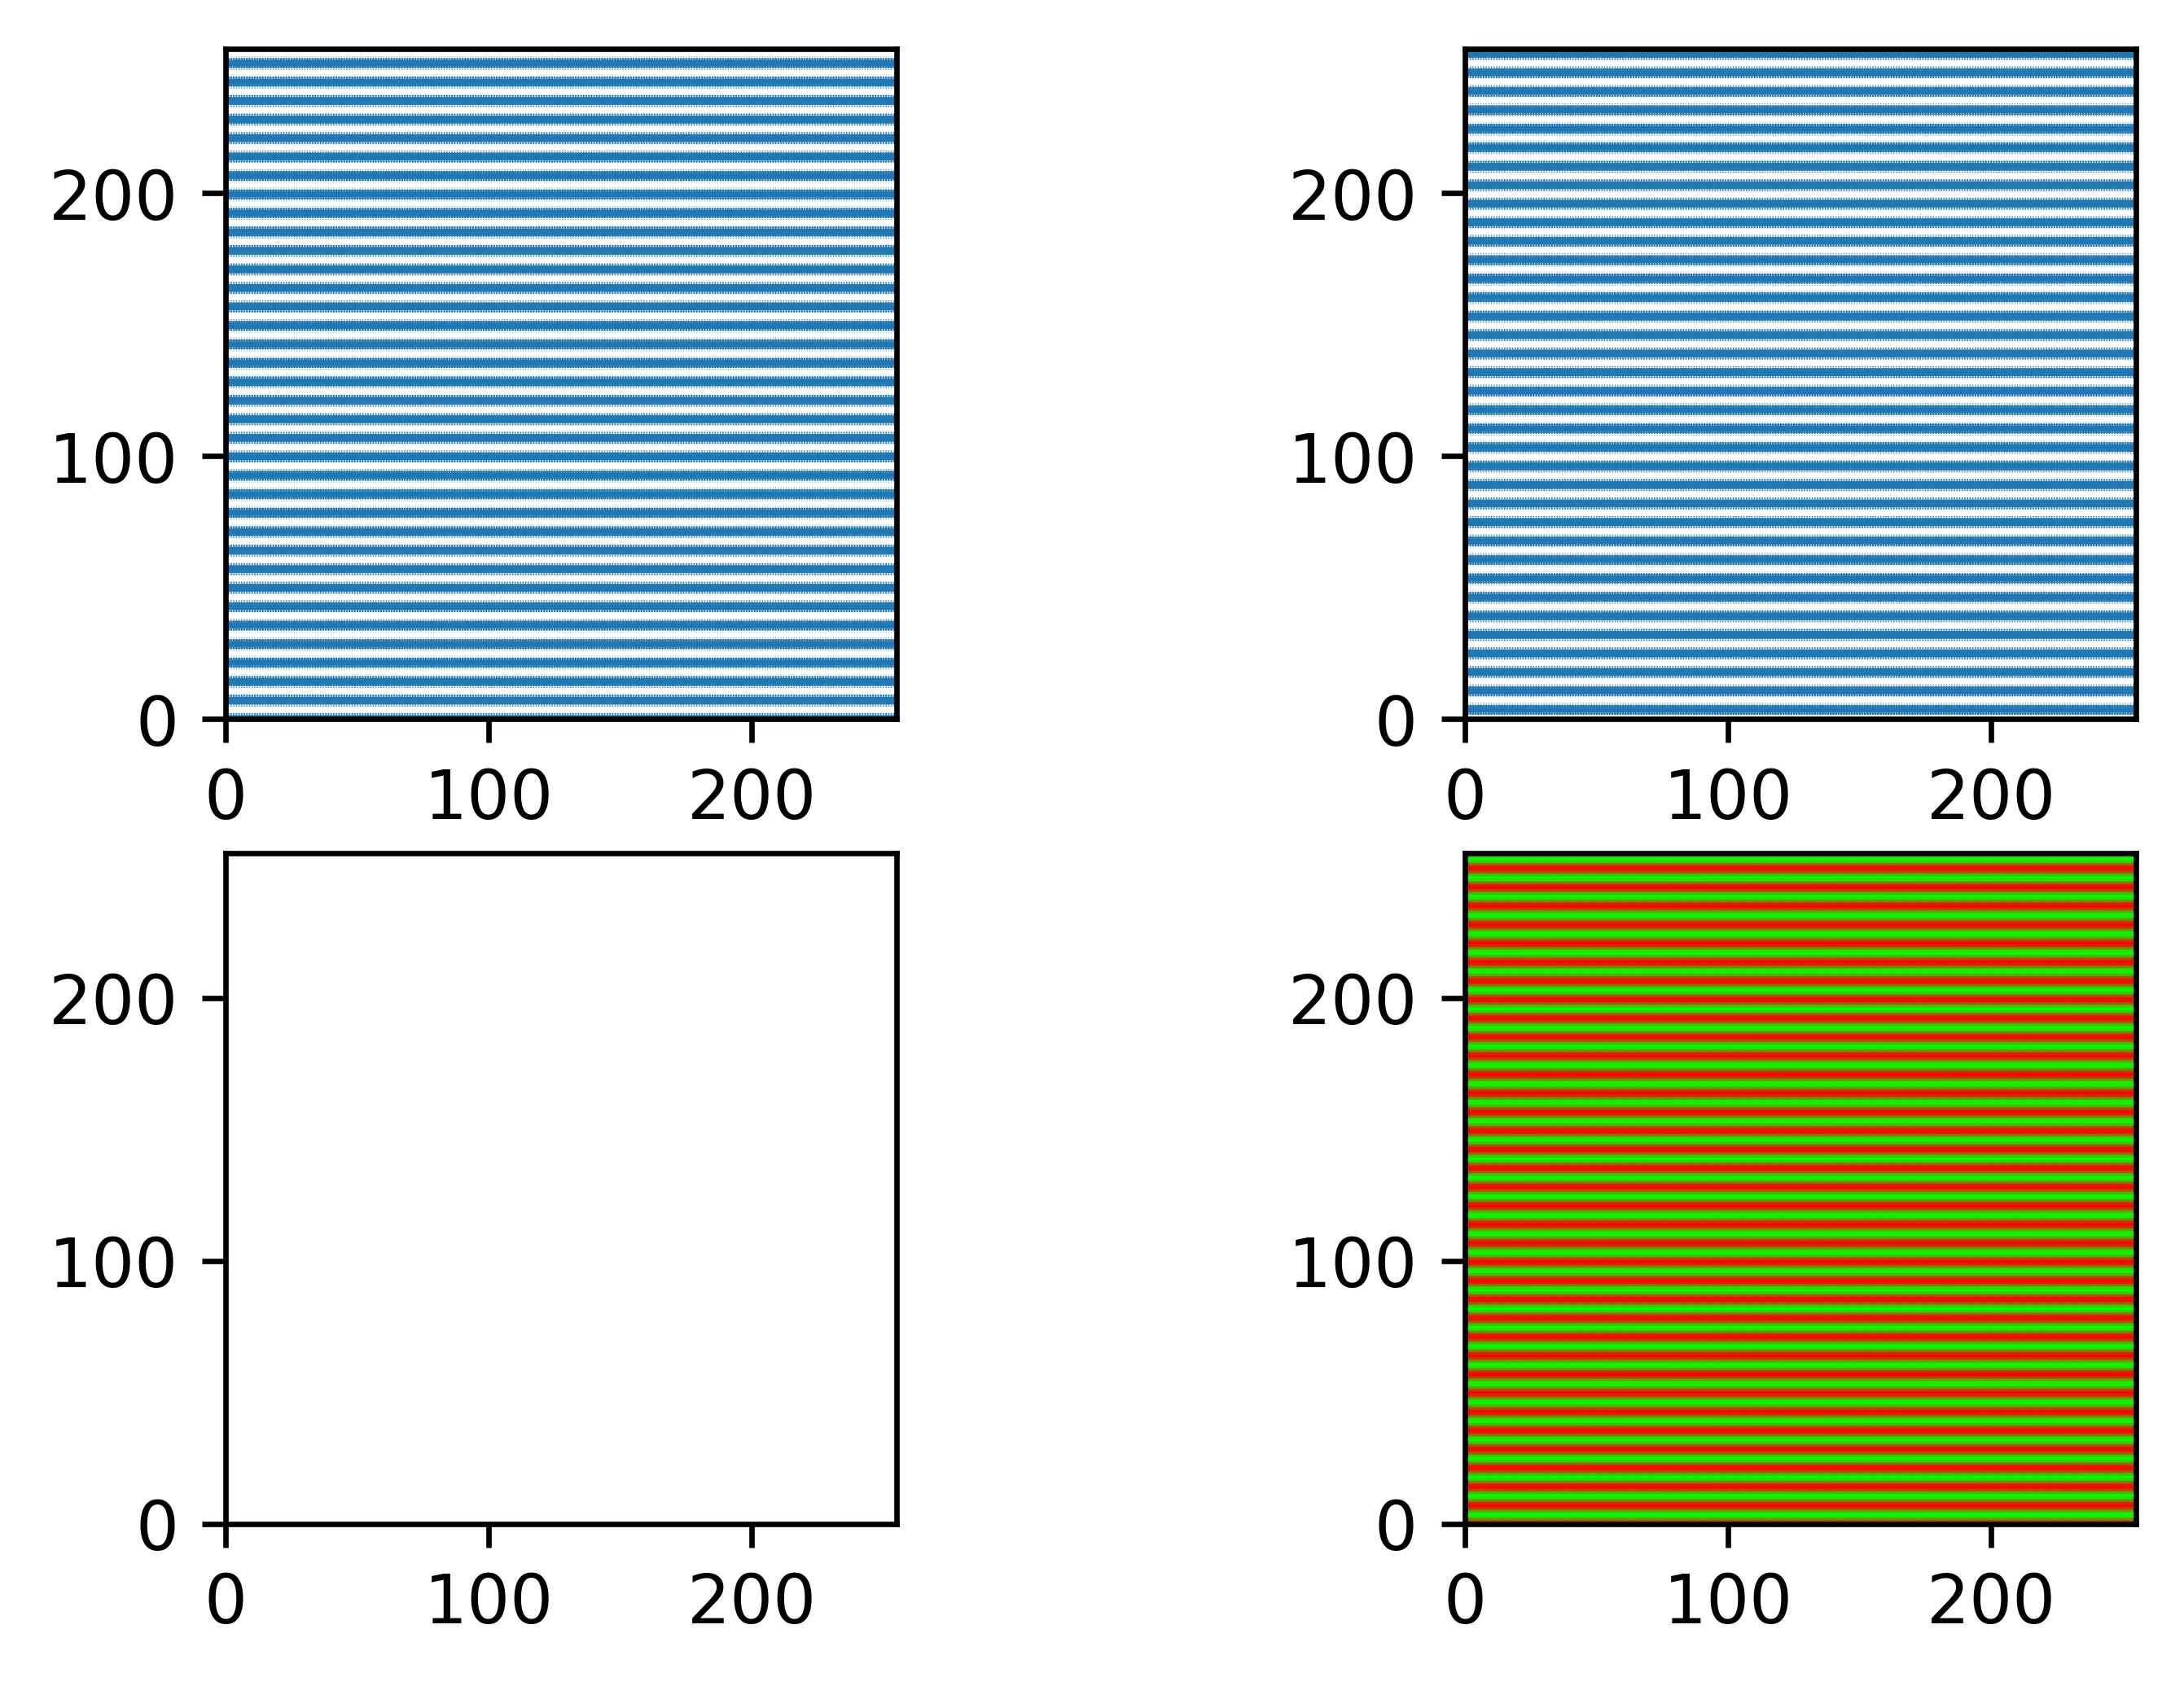

In [22]:
dpi = 600
fig = plt.figure('LMS revisit', dpi = dpi)
it = 13
iseq = 0
xx, yy = np.meshgrid(np.arange(256), np.arange(256))
ax = fig.add_subplot(221)
ax.scatter(xx.flatten(), yy.flatten(), s = (72/dpi*10*LMS_series[iseq][it, 0, np.flipud(yy).flatten(), xx.flatten()])**2, marker='.',linewidths=0.0)
ax.set_xlim([0,255])
ax.set_ylim([0,255])
ax.set_aspect('equal')
ax = fig.add_subplot(222)
ax.scatter(xx.flatten(), yy.flatten(), s = (72/dpi*10*LMS_series[iseq][it, 1, np.flipud(yy).flatten(), xx.flatten()])**2, marker='.',linewidths=0.0)
ax.set_xlim([0,255])
ax.set_ylim([0,255])
ax.set_aspect('equal')
ax = fig.add_subplot(223)
ax.scatter(xx.flatten(), yy.flatten(), s = (72/dpi*10*LMS_series[iseq][it, 2, np.flipud(yy).flatten(), xx.flatten()])**2, marker='.',linewidths=0.0)
ax.set_xlim([0,255])
ax.set_ylim([0,255])
ax.set_aspect('equal')
ax = fig.add_subplot(224)
color = np.reshape(LMS_series[iseq][it, :, np.flipud(yy).flatten(), xx.flatten()], (xx.size, 3))
ax.scatter(xx.flatten(), yy.flatten(), s = (72/dpi)**2, c = color, marker='.',linewidths=0.0)
ax.set_xlim([0,255])
ax.set_ylim([0,255])
ax.set_aspect('equal')

c50 = 0.155, slope = 2.856


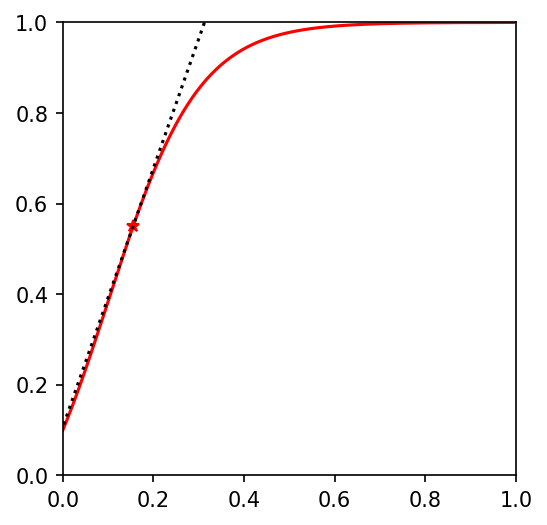

In [13]:
fig = plt.figure('logistic', dpi = 150)
x = np.linspace(0,1,1000)

def logistic0(k, spont, c50, x):
    e_kc50 = np.exp(k*c50)
    e_kc50_k = np.exp(k*(c50-1))
    a = (1-spont)*(1+e_kc50)*(1+e_kc50_k)/(e_kc50-e_kc50_k)
    b = 1 - a/(1+e_kc50_k)
    return a/(1+np.exp(-k*x)*e_kc50) + b

#NOTE: c50 is only a translational paramter in logistic function, the return value of logistic_c50 is the true c50
def logistic_c50(k,c50):
    x = 1+np.exp(k*c50)
    y = 1+np.exp(k*c50-k)
    A = 2*x*y/(x+y)-1
    return c50 - np.log(A)/k

def logistic_slope(k, spont, c50, x):
    e_kc50 = np.exp(k*c50)
    e_kc50_k = np.exp(k*(c50-1))
    a = (1-spont)*(1+e_kc50)*(1+e_kc50_k)/(e_kc50-e_kc50_k)
    return a*k*np.exp(-k*x)*e_kc50/np.power(1+np.exp(-k*x)*e_kc50,2)

intercept = 0.1
translation = 0.1
k = 10

y = logistic0(k, intercept, translation, x)
ax = fig.add_subplot(111)
ax.plot(x, y,'r')
c50 = logistic_c50(k,translation)
y_c50 = (intercept+1)/2
slope = logistic_slope(k,intercept,translation,c50)
print(f'c50 = {c50:.3f}, slope = {slope:.3f}')
ax.plot(c50, y_c50,'*r')

ax.plot([c50-1, c50, c50+1], [y_c50-slope,y_c50,y_c50+slope],':k')
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_aspect('equal')

In [15]:
def cone_isolating(l,m,s,n,lms_wp,rgb_wp,x = None, linear = False, use_XYZ = False): # in 255 and LMS space
    fig = plt.figure('logistic', dpi = 100)
    ax = fig.add_subplot(111)
    l = np.reshape(l,(n,1))
    m = np.reshape(m,(n,1))
    s = np.reshape(s,(n,1))
    lms = np.concatenate([l,m,s],1)
    if use_XYZ:
        rgb = np.matmul(LMS2XYZ, lms.T)
    else:
        rgb = np.matmul(LMS2sRGB, lms.T)
        if not linear:
            rgb = apply_sRGB_gamma(rgb/255)*255
    #rgb = np.matmul(LMS2sRGB, lms.T)
    if x is None:
        x = np.linspace(0,255,n)
    
    onRecord = False
    recordOn = False
    offRecord = False
    x0 = 0
    x1 = 255
    for i in range(n):
        color = rgb[:,i].astype('float').T/255
        if (color>=0).all() and (color<=1).all():
            if not offRecord:
                x0 = x[i]
                Off = color
                lmsOff = np.array([l[i],m[i],s[i]]).T/255
                offRecord = True
            ax.plot(x[i], np.sum(luminance(color, use_XYZ)*255),'.', c=color)
            onColor = color
            lmsOn = np.array([l[i],m[i],s[i]]).T/255
            x1 = x[i]
        else:
            if offRecord and not onRecord:
                recordOn = True
                onRecord = True
        
        if recordOn or i == n-1:
            On = onColor
            recordOn = False
    ax.plot(x,rgb[0,:],'r')
    ax.plot(x,rgb[1,:],'g')
    ax.plot(x,rgb[2,:],'b')
    #ax.plot(l[:-1],np.diff(rgb[2,:]),':b')
    #ax.plot(l[:-1],np.diff(rgb[1,:]),':g')
    ax.plot(np.zeros(255)+lms_wp,np.arange(255),':k')
    ax.plot(np.arange(n), np.zeros(n)+rgb_wp,':k')
    ax.plot(x,np.zeros(x.size),':k')
    ax.plot(x,np.zeros(x.size)+255,':k')
    ax.set_xlim([x0,x1])
    ax.set_ylim([0,255])
    if onRecord and offRecord:
        return On, Off, lmsOn, lmsOff
    else:
        raise Exception('no positive values')

In [16]:
def luminance(rgb, use_XYZ = False):
    if use_XYZ:
        return rgb[1]
    else:
        return np.matmul(sRGB2XYZ[1,:],rgb.reshape((3,1)))

[0.47521427 0.5        0.54445019]
(array([[0.49998918, 0.91991992, 0.49991416]]), array([[0.49998918, 0.03603604, 0.49991416]]))
L:[[0.         0.92460733 0.        ]]
L:[0.         0.83987523 0.        ]


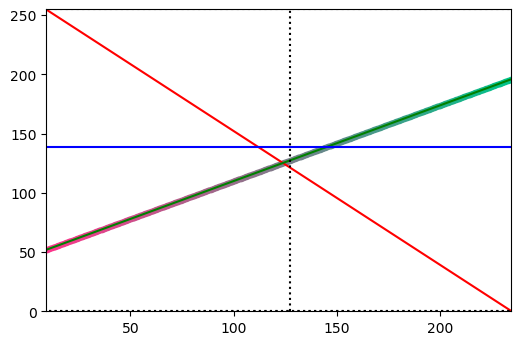

In [116]:
#L-isolating
use_XYZ = True
linear = True
#D65 at 2deg
x = 0.31271
y = 0.32902
Y =  0.5
#Y = 1 #
X = x*Y/y
Z = (1-x-y)*Y/y

wp = np.array([X,Y,Z]).T
if not use_XYZ:
    wp = np.matmul(XYZ2sRGB, wp)
    if not linear:
        wp = apply_sRGB_gamma(wp)
print(f'{wp}')

if use_XYZ:
    LMS_wp = np.matmul(XYZ2LMS, wp)
else:
    if linear:
        LMS_wp = np.matmul(sRGB2LMS, wp)
    else:
        LMS_wp = np.matmul(sRGB2LMS, inverse_sRGB_gamma(wp))
assert((LMS_wp<=1).all())
assert((LMS_wp>0).all())

lum = Y
n = 1000
# L-isolating
#l = np.reshape(np.linspace(0,255,n),(n,1))
#m = np.zeros(n) + LMS_wp[1]*255
# M-isolating
m = np.reshape(np.linspace(0,255,n),(n,1))
l = np.zeros((n,1)) + LMS_wp[0]*255

s = np.zeros((n,1)) + LMS_wp[2]*255

On, Off, lms_On, lms_Off = cone_isolating(l,m,s,n,LMS_wp[0]*255,lum, x=np.linspace(0,255,n), linear = linear, use_XYZ = use_XYZ)
print(f'{lms_On, lms_Off}')
midpoint_con = np.abs(lms_On - lms_Off)/(lms_On + lms_Off)
wp_con = np.min(np.vstack((np.abs(lms_On - LMS_wp)/LMS_wp, np.abs(LMS_wp-lms_Off)/LMS_wp)),0)
print(f'L:{midpoint_con}')
print(f'L:{wp_con}')

[0.61138437 0.61139277 0.61134061]
n=788
rgb = (array([0.99960261, 0.4916256 , 0.6119184 ]), array([0.04124417, 0.73805436, 0.59827713]))
lms = (array([[0.50650651, 0.27006487, 0.3609756 ]]), array([[0.28128128, 0.48617513, 0.3609756 ]]))
wp = [0.31514656 0.3437597  0.3609756 ], lum = 0.3399606192003064
[[0.39389389 0.37812    0.3609756 ]]
[0.28589581 0.2857694  0.        ]
[0.28589581 0.2857694  0.        ]


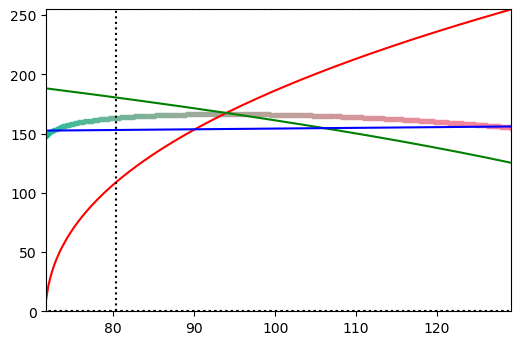

In [52]:
#equiluminant
from ext_signal import *
use_XYZ = False
linear = False
#D65 at 2deg
x = 0.31271
y = 0.32902
Y =  0.332
#Y = 1 #
X = x*Y/y
Z = (1-x-y)*Y/y

wp = np.array([X,Y,Z]).T
if not use_XYZ:
    wp = np.matmul(XYZ2sRGB, wp)
    if not linear:
        wp = apply_sRGB_gamma(wp)
print(f'{wp}')

if use_XYZ:
    LMS_wp = np.matmul(XYZ2LMS, wp)
else:
    if linear:
        LMS_wp = np.matmul(sRGB2LMS, wp)
    else:
        LMS_wp = np.matmul(sRGB2LMS, inverse_sRGB_gamma(wp))
assert((LMS_wp<=1).all())
assert((LMS_wp>0).all())

lum = Y

n = 1000
s = np.zeros((n,1)) + LMS_wp[2]*255
l = np.linspace(0,255,n).reshape(n,1)
m = (Y*255 - LMS2XYZ[1,0]*l + LMS2XYZ[1,2]*s)/LMS2XYZ[1,1]
pick = np.logical_and(m>=0, m<=255)
m = m[pick]
l = l[pick]
s = s[pick]
n = np.sum(pick)
assert(np.logical_and(l>=0,l<=255).all())
assert(np.logical_and(m>=0,m<=255).all())
assert(np.logical_and(s>=0,s<=255).all())
print(f'n={n}')
if use_XYZ:
    lum = wp[1]*255

On, Off, lms_On, lms_Off = cone_isolating(l,m,s,n,LMS_wp[0]*255,lum, x=l, linear = linear, use_XYZ = use_XYZ)

if use_XYZ:
    On = np.matmul(XYZ2sRGB, On)
    Off = np.matmul(XYZ2sRGB, Off)
    if not linear:
        On = apply_sRGB_gamma(On)
        Off = apply_sRGB_gamma(Off)
    print(f'rgb = {On, Off}')
else:
    print(f'rgb = {On, Off}')
print(f'lms = {lms_On, lms_Off}')

LMS_wp0 = np.sum(LMS_wp)/3
print(f'wp = {LMS_wp}, lum = {LMS_wp0}')
print((lms_On + lms_Off)/2)
#LMS_wp0 = LMS_wp
LMS_wp0 = (lms_On + lms_Off)/2
wp_con_min = np.min(np.vstack((np.abs(lms_On - LMS_wp0)/LMS_wp0, np.abs(LMS_wp0-lms_Off)/LMS_wp0)),0)
wp_con_max = np.max(np.vstack((np.abs(lms_On - LMS_wp0)/LMS_wp0, np.abs(LMS_wp0-lms_Off)/LMS_wp0)),0)
print(f'{wp_con_min}')
print(f'{wp_con_max}')

[1.         0.94125885 0.76690457],[0.99999548 1.         0.9999262 ]


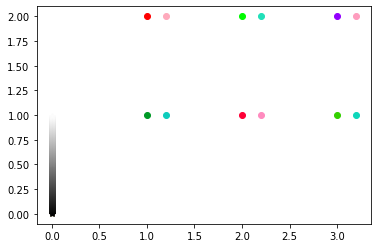

In [210]:
# white point in Reid and Shapley 2002
x = 0.33
y = 0.35
Y = 1
X = Y/y*x
Z = Y/y*(1-x-y)

XYZ = np.array([X,Y,Z])
XYZ2sRGB = np.linalg.inv(sRGB2XYZ)
color = np.matmul(XYZ2sRGB, XYZ.T)

fig = plt.figure('xyY')
ax = fig.add_subplot(111)
ax.plot(0,0, '*', c=color/max(color))
ax.plot(0.2,0, '*', c=wp)
for i in range(100):
    testcolor = np.matmul(LMS2sRGB, np.array([i/100,i/100,i/100]).T)
    ax.plot(0,i/100, '*', c=testcolor)

print(f'{color/max(color)},{wp}')

# Conway 2001
ax.plot(1,2, 'o', c=np.array([255, 0, 0])/256)
ax.plot(1,1, 'o', c=np.array([0, 154, 38])/256)

ax.plot(2,2, 'o', c=np.array([0, 252, 0])/256)
ax.plot(2,1, 'o', c=np.array([255, 0, 55])/256)

ax.plot(3,2, 'o', c=np.array([148, 0, 255])/256)
ax.plot(3,1, 'o', c=np.array([52, 209, 0])/256)

# model
ax.plot(1.2,2, 'o', c=LOn)
ax.plot(1.2,1, 'o', c=LOff)

ax.plot(2.2,2, 'o', c=MOn)
ax.plot(2.2,1, 'o', c=MOff)

ax.plot(3.2,2, 'o', c=SOn)
ax.plot(3.2,1, 'o', c=SOff)

In [ ]:
sum(MOn), sum(MOff)

In [ ]:
RGB2XYZ

In [ ]:
from ext_signal import *

In [ ]:
img_to_LMS('bVHea.png')

In [ ]:
def one_unknown_second_order_equation_solver(a,b,c):
    delta = b**2-4*a*c
    if delta == 0:
        return np.array([-b/2/a])
    else:
        if delta < 0:
            sqrt_delta = 1j*np.sqrt(-delta)
        else:
            sqrt_delta = np.sqrt(delta)
    return np.array([(-b-sqrt_delta)/2/a, (-b+sqrt_delta)/2/a])

def var_triag_dist(a,b,c): 
    return (a**2 + b**2 + c**2 - a*b - b*c -a*c)/18 

# guess and fix
def GAF_triag_dist(a0, b0, m, sd0):
    c0 = 3*m-a0-b0
    var = var_triag_dist(a0, b0, c0)
    p1 = 1
    p2 = -(a0+b0)
    p3 = a0*b0-6*(sd0**2-var)
    b = one_unknown_second_order_equation_solver(p1,p2,p3)[1]
    a = a0+b0-b
    c = c0
    return a, c, b

In [ ]:
m = 63.68
sd0 = 33.06
a0 = 19.41
b0 = 128.10
a, c, b = GAF_triag_dist(a0, b0, m, sd0)
print(a, c, b)

In [ ]:

fig = plt.figure('gauss', dpi=500)
ax = fig.add_subplot(111)
mu = 0
left_std = 2
right_std = 4
x = np.linspace(-30,30,1000) - mu
y = np.copy(x)
#y[x>0] = y[x>0]/right_std
#y[x<0] = y[x<0]/left_std
y = np.sqrt(np.abs(y))
ax.plot(x, np.exp(-np.power(y,2)/2))